# 1. Вес взаимодействия

Прежде, чем строить эксперименты с моделями, необходимо подобрать способ взвешивания взаимодействий пользователей с товарами. Сущесвтует множество подходов кроме бинарного, некоторые из них:

## 1. Кумулятивный вес взаимодействия

### Описание:
Кумулятивный вес учитывает общее количество взаимодействий пользователя с конкретным элементом. Вместо простого наличия или отсутствия взаимодействия, этот метод учитывает частоту повторных взаимодействий.

### Преимущества:
- Учёт предпочтений пользователей, которые часто взаимодействуют с определенными элементами.
- Более точное отображение интересов пользователя.

### Недостатки:
- Не учитывает временную динамику взаимодействий.
- Может переоценивать популярные элементы.

## 2. Взвешенные взаимодействия с использованием временных меток

### Описание:
Этот метод учитывает не только количество взаимодействий, но и их временную последовательность. Свежие взаимодействия могут иметь больший вес, чем более старые.

### Преимущества:
- Отражает текущие интересы пользователя.
- Способствует адаптивности модели к изменениям в поведении пользователя.

### Недостатки:
- Определение оптимальной функции затухания может быть сложным.
- Возможность потери информации о долгосрочных предпочтениях.

## 3. TF-IDF-подобное взвешивание

### Описание:
Использует концепцию TF-IDF (Term Frequency-Inverse Document Frequency) для взвешивания взаимодействий, подчеркивая редкие и важные взаимодействия.

### Преимущества:
- Подчеркивает уникальные предпочтения пользователя.
- Снижает влияние популярных элементов, которые есть у многих пользователей.

### Недостатки:
- Меньшая точность при наличии широкой популярности элементов.
- Сложность реализации в динамических системах.

## 4. Взвешивания на основе популярности элементов

### Описание:
Веса взаимодействий основаны на глобальной популярности элементов. Менее популярные элементы могут иметь больший вес, чтобы избежать смещения в пользу популярных элементов.

### Преимущества:
- Снижает эффект доминирования популярных элементов.
- Поощряет разнообразие рекомендаций.

### Недостатки:
- Может не учитывать реальную вероятность интереса пользователя.
- Требует регулярного обновления популярности элементов.

In [ ]:
!pip install rectools[all]

In [ ]:
!pip install lightfm

In [3]:
import os
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/WBTECH')

Mounted at /content/drive


In [4]:
from rectools.metrics import (
    HitRate,
    Serendipity,
    calc_metrics,
    Recall,
    MAP,
    MRR,
    AvgRecPopularity
)
from rectools import Columns
from rectools.dataset import Dataset

In [5]:
first_train = pd.read_parquet('first_train_2.parquet')
first_val = pd.read_parquet('first_val_2.parquet')

In [6]:
first_train['watched'] = 1
first_val['watched'] = 1

In [7]:
first_train = first_train.rename(
    columns={
        'watched': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)

In [20]:
first_val = first_val.rename(
    columns={
        'watched': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)

In [21]:
first_train_df = Dataset.construct(first_train)
first_val_df = Dataset.construct(first_val)

In [9]:
catalog = first_train[Columns.Item].unique()

In [10]:
from lightfm import LightFM
from rectools.models import LightFMWrapperModel

In [11]:
num_threads = os.cpu_count()

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=15, verbose=1)
model.fit(first_train_df);

Epoch:  73%|███████▎  | 11/15 [00:48<00:17,  4.40s/it]

In [ ]:
%time
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.01 µs


In [ ]:
metrics = {
    "hit_rate@20": HitRate(k=20),
    "serendipity@20": Serendipity(k=20),
    "Recall@20": Recall(k=20),
    "MAP@20": MAP(k=20),
    "MRR@20": MRR(k=20),
    "pop_bias@20": AvgRecPopularity(k=20),
}

calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  
    prev_interactions=first_train,  
    catalog=catalog,  
)

{'hit_rate@20': 0.5314408661854525,
 'Recall@20': 0.28177817375885056,
 'MRR@20': 0.2730269439693359,
 'MAP@20': 0.15074025209283384,
 'pop_bias@20': 1846.90296710161,
 'serendipity@20': 0.00145679889181293}

In [13]:
tf = first_train.groupby(['user_id', 'item_id']).size().reset_index(name='tf')

In [14]:
df = first_train.groupby('item_id')['user_id'].nunique().reset_index(name='df')

In [15]:
N = first_train['user_id'].nunique()
df['idf'] = np.log(N / df['df'])

In [16]:
tf_idf = tf.merge(df, on='item_id')
tf_idf['weight'] = tf_idf['tf'] * tf_idf['idf']

In [17]:
first_train = first_train.merge(tf_idf[['user_id', 'item_id', 'weight']], on=['user_id', 'item_id'], how='left')

In [22]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=15, verbose=1)
model.fit(first_train_df);

Epoch: 100%|██████████| 15/15 [00:49<00:00,  3.33s/it]


In [23]:
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

In [24]:
metrics = {
    "hit_rate@20": HitRate(k=20),
    "serendipity@20": Serendipity(k=20),
    "Recall@20": Recall(k=20),
    "MAP@20": MAP(k=20),
    "MRR@20": MRR(k=20),
    "pop_bias@20": AvgRecPopularity(k=20),
}

calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  
    prev_interactions=first_train,  
    catalog=catalog,  
)

{'hit_rate@20': 0.5191907273736813,
 'Recall@20': 0.27548039637513355,
 'MRR@20': 0.301684047790716,
 'MAP@20': 0.16634590962705165,
 'pop_bias@20': 1801.3892976124375,
 'serendipity@20': 0.0015233372434206478}

In [12]:
first_train = first_train.drop(columns='weight')
first_val = first_val.drop(columns='weight')

In [ ]:
train_df_weights = first_train.groupby(["user_id", "item_id"]).agg({"item_id": "count",}).rename(columns={"item_id": "ui_inter",}).reset_index()

In [ ]:
total_users_interactions_count = train_df_weights[["user_id", "ui_inter"]].groupby("user_id").sum().rename(columns={"ui_inter": "u_total_inter"})

In [ ]:
train_df_weights = train_df_weights.join(
    total_users_interactions_count,
    on="user_id",
    how="left")

train_df_weights["weight"] = train_df_weights["ui_inter"] / train_df_weights["u_total_inter"]

In [ ]:
first_train = first_train.merge(train_df_weights, on=["user_id", "item_id"], how="left")

In [ ]:
first_train["u_entry"] = first_train.groupby(["user_id"]).cumcount() + 1
first_train["ui_entry"] = first_train.groupby(["user_id", "item_id"]).cumcount() + 1

In [ ]:
first_train["ui_entry_inter_ratio"] = first_train["ui_entry"] / first_train["ui_inter"]

first_train["cum_weight"] = first_train["weight"] * first_train["ui_entry_inter_ratio"]

In [ ]:
first_train_1 = first_train.rename(
    columns={
        'watched': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)
first_val_1 = first_val
first_val_1['watched']=1
first_val_1 = first_val.rename(
    columns={
        'watched': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)

In [ ]:
first_train_df = Dataset.construct(first_train_1)
first_val_df = Dataset.construct(first_val_1)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=15, verbose=1)
model.fit(first_train_df);

Epoch: 100%|██████████| 15/15 [00:43<00:00,  2.90s/it]


In [ ]:
%time
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs


In [ ]:
metrics = {
    "hit_rate@20": HitRate(k=20),
    "serendipity@20": Serendipity(k=20),
    "Recall@20": Recall(k=20),
    "MAP@20": MAP(k=20),
    "MRR@20": MRR(k=20),
    "pop_bias@20": AvgRecPopularity(k=20),
}

calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  
    prev_interactions=first_train,  
    catalog=catalog,  
)

{'hit_rate@20': 0.5704469739033871,
 'Recall@20': 0.31430716203847864,
 'MRR@20': 0.30129006135304315,
 'MAP@20': 0.1734375968001548,
 'pop_bias@20': 1789.1518375208216,
 'serendipity@20': 0.0017135318270556615}

In [ ]:
first_train = first_train.drop(columns='weight')

In [ ]:
first_train_1 = first_train.rename(
    columns={
        'cum_weight': Columns.Weight,
        'dt': Columns.Datetime,
        'nm_id': Columns.Item,
        'wbuser_id': Columns.User,
    }
)

In [ ]:
first_train_df = Dataset.construct(first_train_1)
first_val_df = Dataset.construct(first_val_1)

In [ ]:
model = LightFMWrapperModel(LightFM(no_components=100, loss="warp", learning_rate=0.1, max_sampled=5,), num_threads=num_threads, epochs=15, verbose=1)
model.fit(first_train_df);

Epoch: 100%|██████████| 15/15 [00:46<00:00,  3.12s/it]


In [ ]:
%time
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=20,
    filter_viewed=False,
)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [ ]:
calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,  
    prev_interactions=first_train,  
    catalog=catalog,  
)

{'hit_rate@20': 0.579782065519156,
 'Recall@20': 0.3194506305861797,
 'MRR@20': 0.30460562833530586,
 'MAP@20': 0.17580173553095726,
 'pop_bias@20': 1758.0339655052749,
 'serendipity@20': 0.0017715068975873503}

## Лучшим вариантом оказался кумулятивный вес взаимодействия

# 2. Оптимизация гиперпараметров моделей

In [ ]:
!pip install optuna

In [ ]:
!pip install rectools[all]

In [ ]:
!pip install lightfm

In [ ]:
import os
import pandas as pd
import numpy as np
os.chdir(r"C:\..\..\..\WBTECH")

In [ ]:
from rectools.metrics import (
    HitRate,
    Serendipity,
    calc_metrics,
    Recall,
    MAP,
    MRR,
    AvgRecPopularity
)
from rectools import Columns
from rectools.dataset import Dataset

In [ ]:
first_train = pd.read_parquet('first_train_2.parquet')
first_val = pd.read_parquet('first_val_2.parquet')

In [ ]:
first_train = first_train.rename(
    columns={
        'dt': Columns.Datetime,
        'nm_id': 'item_id',
        'wbuser_id': 'user_id',
    }
)

first_val['weight'] = 1
first_val = first_val.rename(
    columns={
        'dt': Columns.Datetime,
        'nm_id': 'item_id',
        'wbuser_id': 'user_id',
    }
)

In [ ]:
train_df_weights = first_train.groupby(["user_id", "item_id"]).agg({"item_id": "count",}).rename(columns={"item_id": "ui_inter",}).reset_index()

In [ ]:
total_users_interactions_count = train_df_weights[["user_id", "ui_inter"]].groupby("user_id").sum().rename(columns={"ui_inter": "u_total_inter"})

In [ ]:
train_df_weights = train_df_weights.join(
    total_users_interactions_count,
    on="user_id",
    how="left")

train_df_weights["weight"] = train_df_weights["ui_inter"] / train_df_weights["u_total_inter"]

In [ ]:
first_train = first_train.merge(train_df_weights, on=["user_id", "item_id"], how="left")

In [ ]:
first_train["u_entry"] = first_train.groupby(["user_id"]).cumcount() + 1
first_train["ui_entry"] = first_train.groupby(["user_id", "item_id"]).cumcount() + 1

In [ ]:
first_train["ui_entry_inter_ratio"] = first_train["ui_entry"] / first_train["ui_inter"]

first_train["cum_weight"] = first_train["weight"] * first_train["ui_entry_inter_ratio"]

In [ ]:
first_train = first_train.drop(columns='weight')
first_train = first_train.rename(
    columns={
        'cum_weight': 'weight',
    }
)

In [ ]:
first_train_df = Dataset.construct(first_train)
first_val_df = Dataset.construct(first_val)

In [ ]:
from rectools.models import PopularModel

model = PopularModel()
model.fit(first_train_df)
recos = model.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=10,
    filter_viewed=False,
)

In [ ]:
catalog = first_train[Columns.Item].unique()

In [ ]:
metrics = {
    "hit_rate@10": HitRate(k=10),
    "serendipity@10": Serendipity(k=10),
    "Recall@10": Recall(k=10),
    "MAP@10": MAP(k=10),
    "MRR@10": MRR(k=10),
    "pop_bias@10": AvgRecPopularity(k=10),
}

popular_metrics = calc_metrics(
    metrics,
    reco=recos,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog,
)

In [ ]:
models_results_df_val = pd.DataFrame(index=list(metrics.keys()))

In [ ]:
models_results_df_val["Popular"] = [popular_metrics[metric] for metric in models_results_df_val.index]

## LightFM

In [ ]:
from lightfm import LightFM
from rectools.models import LightFMWrapperModel

In [ ]:
import optuna
from tqdm.auto import tqdm

In [ ]:
num_threads = os.cpu_count()

In [ ]:
LIGHTFM_N_TRIALS = 50
RANDOM_STATE = 0

In [ ]:
def train_and_calculate_score(model, metrics, head_metric="MAP@10"):
    model.fit(first_train_df)
    recos = model.recommend(first_val[Columns.User].unique(), first_train_df, k=10, filter_viewed=False)
    metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=first_val,
            prev_interactions=first_train,
            catalog=catalog,
    )

    return metric_values[head_metric]

In [ ]:
def lightfm_objective(trial: optuna.Trial):
    global metrics

    loss = trial.suggest_categorical("loss", ['bpr', 'warp'])
    no_components = trial.suggest_categorical("no_components", [150, 200, 250, 300, 350, 400, 450, 500, 550, 600])
    learning_rate = trial.suggest_categorical("learning_rate", [1e-2, 5e-2, 1e-1])
    epochs = trial.suggest_categorical("epochs", [6, 9, 12, 15, 18, 21])
    learning_schedule = trial.suggest_categorical("learning_schedule", ['adagrad', 'adadelta'])
    max_sampled = trial.suggest_categorical("max_sampled", [5, 10, 20, 40])

    lightfm_model = LightFMWrapperModel(
        model=LightFM(
            no_components=no_components,
            loss=loss,
            learning_rate=learning_rate,
            learning_schedule=learning_schedule,
            max_sampled=max_sampled,
            random_state=RANDOM_STATE,
        ),
        num_threads=num_threads,
        epochs=epochs,
        verbose=False
    )

    score = train_and_calculate_score(lightfm_model, metrics)
    return score

In [ ]:
lightfm_study = optuna.create_study(direction="maximize", study_name="LightFM", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.NopPruner())
lightfm_study.optimize(lightfm_objective, n_trials=LIGHTFM_N_TRIALS)

In [ ]:
print("Параметры лучшей модели: ", lightfm_study.best_params)
print("MAP@10 лучшей модели: ", lightfm_study.best_value)

Параметры лучшей модели:  {'loss': 'warp', 'no_components': 500, 'learning_rate': 0.05, 'epochs': 21, 'learning_schedule': 'adadelta', 'max_sampled': 10}
MAP@10 лучшей модели:  0.21365722669743137


In [ ]:
best_lightfm_params = lightfm_study.best_params.copy()
epochs = best_lightfm_params["epochs"]
del best_lightfm_params["epochs"]
best_lightfm_model = LightFMWrapperModel(
    model=LightFM(**best_lightfm_params),
    num_threads=num_threads,
    epochs=epochs,
    verbose=False
)
best_lightfm_model.fit(first_train_df)

In [ ]:
lightfm_reco_df = best_lightfm_model.recommend(first_val[Columns.User].unique(), first_train_df, k=10, filter_viewed=False)

In [ ]:
lightfm_reco_df.to_parquet('lfm_wof_val.parquet')

In [ ]:
lightfm_metrics = calc_metrics(
    metrics,
    reco=lightfm_reco_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog,
)

models_results_df_val["LightFM"] = [lightfm_metrics[metric] for metric in models_results_df_val.index]

In [ ]:
models_results_df_val.to_parquet('models_results_df_val.parquet')

Стоит отметить, что и на 30 эпохах модель явно не обучилась. Вероятно это так же причина того, что при добавлении признаков результаты не улучшаются, а чаще ухудшаются. При добавлении признаков модель показывает результаты намного лучше, если увеличивать параметр max_sampled, что логично. Но так как модель обучалась на моем компьютере через Docker, очень быстро были достигнуты пределы, после которых модель обучалась слишком долго. Поэтому было решено использовать эту модель без признаков

## KNN

In [ ]:
from rectools.models import ImplicitItemKNNWrapperModel
from implicit.nearest_neighbours import TFIDFRecommender, BM25Recommender, CosineRecommender

In [ ]:
ITEMKNN_K_RECOMMENDATIONS = 10
ITEMKNN_N_TRIALS = 10

In [ ]:
filtered_first_val = first_val[first_val['user_id'].isin(first_train['user_id'])]
first_val_df = Dataset.construct(filtered_first_val)

In [ ]:
def train_and_calculate_score(model, metrics, head_metric="MAP@10"):
    model.fit(first_train_df)
    recos = model.recommend(filtered_first_val[Columns.User].unique(), first_train_df, k=10, filter_viewed=False)
    metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=filtered_first_val,
            prev_interactions=first_train,
            catalog=catalog,
    )

    return metric_values[head_metric]

In [ ]:
def itemknn_objective(trial: optuna.Trial):
    global metrics

    recommender_type = trial.suggest_categorical("type", ['cosine', 'bm25', 'tfidf'])
    if recommender_type == 'cosine':
        recommender = CosineRecommender(
            K=ITEMKNN_K_RECOMMENDATIONS,
            num_threads=num_threads,
        )
    elif recommender_type == 'bm25':
        k1 = trial.suggest_categorical("k1", [0.8, 1.2, 1.5])
        b = trial.suggest_categorical("b", [0.3, 0.7, 1])
        recommender = BM25Recommender(
            K=ITEMKNN_K_RECOMMENDATIONS,
            num_threads=num_threads,
            K1=k1,
            B=b,
        )
    else:
        recommender = TFIDFRecommender(
            K=ITEMKNN_K_RECOMMENDATIONS,
            num_threads=num_threads,
        )

    itemknn_model = ImplicitItemKNNWrapperModel(
        recommender,
        verbose=False,
    )
    score = train_and_calculate_score(itemknn_model, metrics)
    return score

In [ ]:
itemknn_study = optuna.create_study(direction="maximize", study_name="ItemKNN", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.NopPruner())
itemknn_study.optimize(itemknn_objective, n_trials=ITEMKNN_N_TRIALS)

In [ ]:
print("Параметры лучшей модели: ", itemknn_study.best_params)
print("MAP@10 лучшей модели: ", itemknn_study.best_value)

Параметры лучшей модели:  {'type': 'bm25', 'k1': 0.8, 'b': 0.3}
MAP@10 лучшей модели:  0.25403057016778824


In [ ]:
best_itemknn_model = ImplicitItemKNNWrapperModel(
    model = BM25Recommender(
        K=ITEMKNN_K_RECOMMENDATIONS,
        num_threads=num_threads,
        K1=0.8,
        B=0.3
    ),
    verbose=False
)
best_itemknn_model.fit(first_train_df)

In [ ]:
itemknn_reco_df = best_itemknn_model.recommend(filtered_first_val[Columns.User].unique(), first_train_df, k=ITEMKNN_K_RECOMMENDATIONS, filter_viewed=False)

In [ ]:
models_results_df_val = pd.read_parquet('models_results_df_val.parquet')

In [ ]:
itemknn_metrics = calc_metrics(
    metrics=metrics,
    reco=itemknn_reco_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)
models_results_df_val["ItemKNN_BM25"] = [itemknn_metrics[metric] for metric in models_results_df_val.index]

In [ ]:
second_itemknn_model = ImplicitItemKNNWrapperModel(
    model = TFIDFRecommender(
            K=ITEMKNN_K_RECOMMENDATIONS,
            num_threads=num_threads,
        ),
    verbose=False
)
second_itemknn_model.fit(first_train_df)

In [ ]:
itemknn_2_reco_df = second_itemknn_model.recommend(filtered_first_val[Columns.User].unique(), first_train_df, k=ITEMKNN_K_RECOMMENDATIONS, filter_viewed=False)

In [ ]:
second_itemknn_metrics = calc_metrics(
    metrics=metrics,
    reco=itemknn_2_reco_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)
models_results_df_val["ItemKNN_TF-IDF"] = [second_itemknn_metrics[metric] for metric in models_results_df_val.index]

In [ ]:
itemknn_reco_df.to_parquet('bm25_val.parquet')
itemknn_2_reco_df.to_parquet('tfidf_val.parquet')

Самые быстрые в обучении модели, которые имеют наибольшее значение MAP.

## EASE

In [ ]:
from rectools.models import EASEModel

In [ ]:
regularizations = [256, 512, 1024, 2048, 4096]

In [ ]:
from tqdm import tqdm

In [ ]:
results = []

for regularization in tqdm(regularizations):
            model_name = f"EASE_reg_{regularization}"
            ease_model = EASEModel(
                regularization = regularization,
            num_threads=num_threads,
            )
            ease_model.fit(first_train_df)
            recos = ease_model.recommend(
                users=filtered_first_val[Columns.User].unique(),
                dataset=first_train_df,
                k=10,
                filter_viewed=False,
            )
            metric_values = calc_metrics(metrics, recos, first_val, first_train, catalog)
            metric_values["ease_model"] = model_name
            results.append(metric_values)

100%|██████████| 5/5 [59:07<00:00, 709.59s/it]


In [ ]:
pure_df = pd.DataFrame(results).set_index("ease_model").sort_values(by=["MAP@10"], ascending=False)

In [ ]:
pure_df

,hit_rate@10,Recall@10,MRR@10,MAP@10,pop_bias@10,serendipity@10
ease_model,,,,,,
EASE_reg_2048,0.388187,0.186988,0.224170,0.108618,1198.877205,0.002314
EASE_reg_4096,0.390339,0.187639,0.224055,0.108487,1337.183528,0.002278
EASE_reg_1024,0.385515,0.185886,0.223421,0.108171,1026.210403,0.002364
EASE_reg_512,0.381351,0.183639,0.221966,0.107546,845.676067,0.002429
EASE_reg_256,0.374931,0.179987,0.219343,0.106071,686.332998,0.002488


In [ ]:
best_ease_model = EASEModel(
        regularization = 2048,
        num_threads=num_threads,
    )
best_ease_model.fit(first_train_df)

In [ ]:
ease_reco_df = best_ease_model.recommend(filtered_first_val[Columns.User].unique(), first_train_df, k=10, filter_viewed=False)

In [ ]:
ease_metrics = calc_metrics(
    metrics=metrics,
    reco=ease_reco_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)
models_results_df_val["EASE"] = [ease_metrics[metric] for metric in models_results_df_val.index]

In [ ]:
ease_reco_df.to_parquet('ease_val.parquet')

Самые слабые результаты среди всех моделей. Возможно данная модель проявляет себя лучше с меньшим числом товаров и более богатой историей взаимодействий.

## iALS

In [ ]:
import threadpoolctl
from implicit.als import AlternatingLeastSquares
from rectools.models import ImplicitALSWrapperModel

In [ ]:
# For implicit ALS
os.environ["OPENBLAS_NUM_THREADS"] = "1"
threadpoolctl.threadpool_limits(1, "blas")

In [ ]:
def ials_objective(trial: optuna.Trial):
    global metrics

    factors = trial.suggest_categorical("factors", [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600])
    regularization = trial.suggest_categorical("regularization", [1e-2, 5e-2, 1e-1, 5e-1])
    iterations = trial.suggest_categorical("iterations", [6, 9, 12, 15, 18, 21])
    alpha = trial.suggest_categorical("max_sampled", [1, 10, 25, 50, 100])

    ials_model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            iterations = iterations,
            random_state=0,
            use_gpu=False,
            num_threads = num_threads),
    )

    score = train_and_calculate_score(ials_model, metrics)
    return score

In [ ]:
ials_study = optuna.create_study(direction="maximize", study_name="iALS", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.NopPruner())
ials_study.optimize(ials_objective, n_trials=50)

In [ ]:
print("Параметры лучшей модели: ", ials_study.best_params)
print("MAP@10 лучшей модели: ", ials_study.best_value)

Параметры лучшей модели:  {'factors': 600, 'regularization': 0.01, 'iterations': 6, 'max_sampled': 100}
MAP@10 лучшей модели:  0.2536875652195201


In [ ]:
best_ials_model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=600,
            regularization=0.01,
            alpha=100,
            iterations = 6,
            random_state=0,
            use_gpu=False,
            num_threads = num_threads),
    )
best_ials_model.fit(first_train_df)

In [ ]:
ials_reco_df = best_ials_model.recommend(filtered_first_val[Columns.User].unique(), first_train_df, k=10, filter_viewed=False)

In [ ]:
models_results_df_val = pd.read_parquet('models_results_df_val.parquet')

In [ ]:
ials_metrics = calc_metrics(
    metrics=metrics,
    reco=ials_reco_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)
models_results_df_val["iALS"] = [ials_metrics[metric] for metric in models_results_df_val.index]

In [ ]:
models_results_df_val.to_parquet('models_results_df_val.parquet')

In [ ]:
items = pd.read_parquet('items_min_wo_emb.parquet')

In [ ]:
items = items.rename(columns={'nm_id': Columns.Item})

In [ ]:
items = items.loc[items[Columns.Item].isin(first_train[Columns.Item])].copy()

In [ ]:
items = items.loc[:, (items != 0).any(axis=0)]

In [ ]:
binary_cols = [col for col in items.columns if items[col].nunique() == 2 and col != 'item_id']

numeric_cols = [col for col in items.select_dtypes(include=[np.number]).columns if col not in binary_cols + ['item_id']]

In [ ]:
def bin_numeric_columns_into_binary(df, numeric_cols, max_bins=5):

       binary_dfs = []

       for col in numeric_cols:
           try:
               bins = pd.qcut(df[col], q=max_bins, duplicates='drop')

               dummies = pd.get_dummies(bins, prefix=col)

               binary_dfs.append(dummies)

           except ValueError as e:
               print(f"Не удалось разбить колонку '{col}' на {max_bins} квантилей: {e}")

               unique_vals = df[col].unique()
               dummies = pd.get_dummies(df[col], prefix=f"{col}_bin")
               binary_dfs.append(dummies)

       binary_features = pd.concat(binary_dfs, axis=1)

       df_binned = pd.concat([df.drop(columns=numeric_cols), binary_features], axis=1)

       return df_binned

In [ ]:
items = bin_numeric_columns_into_binary(items, numeric_cols, max_bins=5)

In [ ]:
items *= 1

In [ ]:
features_dataset = Dataset.construct(
    interactions_df=first_train,
    item_features_df=items,
    make_dense_item_features=True
)

In [ ]:
def train_and_calculate_score(model, metrics, head_metric="MAP@10"):
    model.fit(features_dataset)
    recos = model.recommend(filtered_first_val[Columns.User].unique(), features_dataset, k=10, filter_viewed=False)
    metric_values = calc_metrics(
            metrics,
            reco=recos,
            interactions=filtered_first_val,
            prev_interactions=first_train,
            catalog=catalog,
    )

    return metric_values[head_metric]

In [ ]:
def fials_objective(trial: optuna.Trial):
    global metrics

    factors = trial.suggest_categorical("factors", [300, 350, 400, 450, 500, 550, 600, 650, 700])
    regularization = trial.suggest_categorical("regularization", [1e-2, 5e-2, 1e-1, 5e-1, 1])
    iterations = trial.suggest_categorical("iterations", [6, 9, 12, 15, 18, 21])
    alpha = trial.suggest_categorical("max_sampled", [25, 50, 75, 100, 125, 150])

    ials_model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=factors,
            regularization=regularization,
            alpha=alpha,
            iterations = iterations,
            random_state=0,
            use_gpu=False,
            num_threads = num_threads),
    )

    score = train_and_calculate_score(ials_model, metrics)
    return score

In [ ]:
fials_study = optuna.create_study(direction="maximize", study_name="iALS_with_feat", sampler=optuna.samplers.TPESampler(), pruner=optuna.pruners.NopPruner())
fials_study.optimize(fials_objective, n_trials=50)

In [ ]:
print("Параметры лучшей модели: ", fials_study.best_params)
print("MAP@10 лучшей модели: ", fials_study.best_value)

Параметры лучшей модели:  {'factors': 400, 'regularization': 0.01, 'iterations': 18, 'max_sampled': 125}
MAP@10 лучшей модели:  0.2573499683274119


In [ ]:
best_fials_model = ImplicitALSWrapperModel(
        AlternatingLeastSquares(
            factors=300,
            regularization=0.01,
            alpha=150,
            iterations = 9,
            random_state=0,
            use_gpu=False,
            num_threads = num_threads),
    )
best_fials_model.fit(features_dataset)

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
fials_reco_df = best_fials_model.recommend(filtered_first_val[Columns.User].unique(), features_dataset, k=10, filter_viewed=False)

In [ ]:
fials_reco_df.to_parquet('ials_feat_val.parquet')

In [ ]:
fials_metrics = calc_metrics(
    metrics=metrics,
    reco=fials_reco_df,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)
models_results_df_val["iALS_w_f"] = [fials_metrics[metric] for metric in models_results_df_val.index]

In [ ]:
fials_metrics

{'hit_rate@10': 0.556947529150472,
 'Recall@10': 0.3257565241532482,
 'MRR@10': 0.37502674329957775,
 'MAP@10': 0.23185035402510074,
 'pop_bias@10': 713.5270792365529,
 'serendipity@10': 0.004389848605377838}

In [ ]:
models_results_df_val.to_parquet('models_results_df_val.parquet')

Как мы видим для iALS признаки дали минимальное улучшение. Наиболее вероятная причина - из-за уменьшения датасета потерялась информативность признаков, они больше не характеризуют определенные группы товаров, которые могли бы дополнить коллаборативные рекомендации.

## Рекомендации по косинусной схожести между эмбеддингами изображений айтемов и последним просмотренным айтемом

In [ ]:
items = pd.read_parquet('items_full.parquet')

In [ ]:
items = items.rename(columns={'nm_id': Columns.Item})

In [ ]:
emb_columns = [f"emb_{i}" for i in range(256)] #для 256
items = items[['item_id'] + emb_columns]

In [ ]:
!pip install faiss-cpu

In [ ]:
items_embeddings = items.set_index('item_id')

In [ ]:
item_ids = items_embeddings.index.values  
embeddings = items_embeddings.values.astype('float32')  

In [ ]:
import faiss

faiss.omp_set_num_threads(num_threads)

In [ ]:
d = embeddings.shape[1]

index = faiss.IndexFlatL2(d)

index.add(embeddings)

In [ ]:
last_interactions = first_train.groupby('user_id').tail(1).reset_index(drop=True)

In [ ]:
results = []
top_N = 10  
index_to_item_id = dict(enumerate(item_ids))  

In [ ]:
from sklearn.preprocessing import normalize

normalized_embeddings = normalize(embeddings, norm='l2', axis=1)

d = normalized_embeddings.shape[1]

index = faiss.IndexFlatIP(d)

index.add(normalized_embeddings)

In [ ]:
for idx, row in last_interactions.iterrows():
    user_id = row['user_id']
    last_item_id = row['item_id']

    last_item_index = items_embeddings.index.get_loc(last_item_id)

    last_item_emb = normalized_embeddings[last_item_index].reshape(1, -1)

    similarities, indices = index.search(last_item_emb, top_N + 1)
    similarities = similarities.flatten()
    indices = indices.flatten()

    mask = indices != last_item_index
    filtered_similarities = similarities[mask][:top_N]
    filtered_indices = indices[mask][:top_N]

    recommended_item_ids = [index_to_item_id[i] for i in filtered_indices]

    filtered_distances = 1 - filtered_similarities

    ranks = np.arange(1, len(recommended_item_ids) + 1)
    for rank, item_id, score in zip(ranks, recommended_item_ids, filtered_distances):
        results.append({
            'user_id': user_id,
            'item_id': item_id,
            'score': score,
            'rank': rank
        })

In [ ]:
recommendations_df = pd.DataFrame(results)
recommendations_df = recommendations_df[['user_id', 'item_id', 'score', 'rank']]
recommendations_df = recommendations_df.sort_values(by=['user_id', 'rank']).reset_index(drop=True)

In [ ]:
recommendations_df_val = recommendations_df[recommendations_df['user_id'].isin(filtered_first_val['user_id'])]

In [ ]:
img_metrics = calc_metrics(
    metrics=metrics,
    reco=recommendations_df_val,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)
img_metrics # cosine_4096

{'hit_rate@10': 0.0021515824541921153,
 'Recall@10': 0.000694058856191005,
 'MRR@10': 0.0005172253289618642,
 'MAP@10': 0.0001618713258947851,
 'pop_bias@10': 107.75564295353767,
 'serendipity@10': 9.785648831163205e-06}

In [ ]:
img_metrics = calc_metrics(
    metrics=metrics,
    reco=recommendations_df_val,
    interactions=first_val,
    prev_interactions=first_train,
    catalog=catalog
)
img_metrics # cosine_256

{'hit_rate@10': 0.003609106052193226,
 'Recall@10': 0.0013197859654689192,
 'MRR@10': 0.0009701400456536492,
 'MAP@10': 0.0003941974948409865,
 'pop_bias@10': 110.6365162907268,
 'serendipity@10': 1.3214953620536892e-05}

Как мы видим, результаты околонулевые. Наиболее вероятная причина в том, что датасет был уменьшен: товаров в разы меньше, следующее взаимодействие пользователя на самом деле таким не является.

## Итоговые значения метрик для моделей первого уровня

Значения в данной таблице немного ниже, чем будут в тестовой, так как в валидационной выборке были холодные пользователи. В презентации отдельно будут значения MAP моделей только для теплых пользователей.

In [ ]:
models_results_df_val

,Popular,LightFM,ItemKNN_BM25,ItemKNN_TF-IDF,EASE,iALS,iALS_w_f
hit_rate@10,1.013673e-01,0.575687,0.544836,0.537514,0.388187,0.555455,0.556948
serendipity@10,9.087599e-07,0.003547,0.004354,0.004308,0.002314,0.004471,0.004390
Recall@10,3.399385e-02,0.323716,0.315753,0.312188,0.186988,0.324820,0.325757
MAP@10,1.221302e-02,0.218699,0.228633,0.227064,0.108618,0.228324,0.231850
MRR@10,3.863950e-02,0.368995,0.370727,0.368268,0.224170,0.370355,0.375027
pop_bias@10,4.975100e+03,2033.098289,594.603433,586.087617,1198.877205,643.046235,713.527079


### Из того, что еще не получилось:

TIFU KNN требует, чтобы пользователи были представлены как векторы размерностью в количество айтемов. Для формирования этого итогового вектора требуется еще больше памяти и огромное количество векторных вычислений. Поэтому по итогу я решил не использовать этот метод, посчитав его неподходящим для данной задачи.

In [ ]:
models_results_df_val.to_parquet('models_results_df_val.parquet')

# 3. Собираем итоговый датасет кандидатов для модели второго уровня

In [ ]:
first_val = filtered_first_val

In [ ]:
popmpd = PopularModel()
popmpd.fit(first_train_df)
popular_reco_df = popmpd.recommend(
    users=first_val[Columns.User].unique(),
    dataset=first_train_df,
    k=10,
    filter_viewed=False,
)

In [ ]:
lightfm_recommendations_df = pd.read_parquet("lfm_wof_val.parquet")
lightfm_recommendations_df = lightfm_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
lightfm_recommendations_df = lightfm_recommendations_df.rename({"score": "lightfm_score", "rank": "lightfm_rank"}, axis=1)

In [ ]:
bm_25_recommendations_df = pd.read_parquet("bm25_val.parquet")
bm_25_recommendations_df = bm_25_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
bm_25_recommendations_df = bm_25_recommendations_df.rename({"score": "bm_25_score", "rank": "bm_25_rank"}, axis=1)

In [ ]:
lightfm_recommendations_df = lightfm_recommendations_df[lightfm_recommendations_df['user_id'].isin(bm_25_recommendations_df['user_id'].unique())]

In [ ]:
tfidf_recommendations_df = pd.read_parquet("tfidf_val.parquet")
tfidf_recommendations_df = tfidf_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
tfidf_recommendations_df = tfidf_recommendations_df.rename({"score": "tfidf_score", "rank": "tfidf_rank"}, axis=1)

In [ ]:
ease_recommendations_df = pd.read_parquet("ease_val.parquet")
ease_recommendations_df = ease_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
ease_recommendations_df = ease_recommendations_df.rename({"score": "ease_score", "rank": "ease_rank"}, axis=1)

In [ ]:
ials_recommendations_df = pd.read_parquet("ials_val.parquet")
ials_recommendations_df = ials_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
ials_recommendations_df = ials_recommendations_df.rename({"score": "ials_score", "rank": "ials_rank"}, axis=1)

In [ ]:
ials_feat_recommendations_df = pd.read_parquet("ials_feat_val.parquet")
ials_feat_recommendations_df = ials_feat_recommendations_df.astype(
    {'user_id': 'int32', 'item_id': 'int32', 'score': 'float32', 'rank': 'int16'}
)
ials_feat_recommendations_df = ials_feat_recommendations_df.rename({"score": "ials_feat_score", "rank": "ials_feat_rank"}, axis=1)

In [ ]:
recommendations_df = (
    pd.merge(
        popular_reco_df,
        lightfm_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [ ]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        bm_25_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [ ]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        tfidf_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [ ]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        ease_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [ ]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        ials_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [ ]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        ials_feat_recommendations_df,
        how='outer',
        on=['user_id', 'item_id']
    )
)

In [ ]:
recommendations_df = recommendations_df.rename({"score": "popular_score", "rank": "popular_rank"}, axis=1)

In [ ]:
recommendations_df = (
    pd.merge(
        recommendations_df,
        first_val[['user_id', 'item_id', 'weight']].drop_duplicates(),
        how='left',
        on=['user_id', 'item_id']
    )
)

In [ ]:
recommendations_df = (
    recommendations_df
    .fillna(
        {
            'lightfm_score': -101, 'lightfm_rank': 101,
            'bm_25_score': -101, 'bm_25_rank': 101,
            'popular_score': -101, 'popular_rank': 101,
            'tfidf_score': -101, 'tfidf_rank': 101,
            'ease_score': -101, 'ease_rank': 101,
            'ials_score': -101, 'ials_rank': 101,
            'ials_feat_score': -101, 'ials_feat_rank': 101,
            'weight': 0
        }
    )
    .astype(
        {
            'user_id': 'int32', 'item_id': 'int32', 'weight': 'float16',
            'lightfm_score': 'float16', 'lightfm_rank': 'int16',
            'bm_25_score': 'float16', 'bm_25_rank': 'int16',
            'popular_score': 'float16', 'popular_rank': 'int16',
            'tfidf_score': 'float16', 'tfidf_rank': 'int16',
            'ease_score': 'float16', 'ease_rank': 'int16',
            'ials_score': 'float16', 'ials_rank': 'int16',
            'ials_feat_score': 'float16', 'ials_feat_rank': 'int16',
        }
    )

)

In [ ]:
recommendations_df.to_parquet('recommendations_df_val_without_last_features.parquet')

## Дополнительные признаки

Так как не вышло сделать модель на схожести эмбеддингов изображений, я решил добавить косинусное расстояние между кандидатом и последним просмотренным айтемом и между кандидатом и последним просмотренным айтемом.

Так же я добавлю среднюю нормализованную совстречаемость кандидатов с товарами, которые пользователь уже просматривал.

In [ ]:
items_embeddings_normalized = pd.DataFrame(
    normalize(items_embeddings, norm='l2', axis=1),
    index=items_embeddings.index,
    columns=emb_columns
)

In [ ]:
last_item_embeddings = last_interactions.merge(items_embeddings_normalized, on='item_id', how='left')
last_item_embeddings = last_item_embeddings[['user_id'] + emb_columns].set_index('user_id')

In [ ]:
user_avg_embeddings = first_train.merge(items_embeddings_normalized, on='item_id', how='left')
user_avg_embeddings = user_avg_embeddings.groupby('user_id')[emb_columns].mean()

In [ ]:
recommendations_with_emb = recommendations_df.merge(
    items_embeddings_normalized,
    on='item_id',
    how='left',
)

In [ ]:
recommendations_with_emb = recommendations_with_emb.merge(
    last_item_embeddings,
    on='user_id',
    how='left',
    suffixes=('', '_last')
)

In [ ]:
def compute_cosine_similarity(row, emb_cols):
    candidate_emb = row[[f"emb_{i}" for i in range(256)]].values
    last_emb = row[[f"emb_{i}_last" for i in range(256)]].values
    return np.dot(candidate_emb, last_emb)

In [ ]:
recommendations_with_emb['cosine_sim_last'] = recommendations_with_emb.apply(
    lambda row: compute_cosine_similarity(row, emb_columns), axis=1
)

In [ ]:
recommendations_with_emb = recommendations_with_emb.merge(
    user_avg_embeddings,
    on='user_id',
    how='left',
    suffixes=('', '_avg')
)

In [ ]:
def compute_cosine_similarity_avg(row, emb_cols):
    candidate_emb = row[[f"emb_{i}" for i in range(256)]].values
    avg_emb = row[[f"emb_{i}_avg" for i in range(256)]].values
    return np.dot(candidate_emb, avg_emb)

In [ ]:
recommendations_with_emb['cosine_sim_avg'] = recommendations_with_emb.apply(
    lambda row: compute_cosine_similarity_avg(row, emb_columns), axis=1
)

In [ ]:
recommendations_df[['cosine_sim_last', 'cosine_sim_avg']] = recommendations_with_emb[['cosine_sim_last', 'cosine_sim_avg']]

In [ ]:
recommendations_df = recommendations_df.merge(
    items[['item_id', 'item_popul']],
    on='item_id',
    how='left',
)

In [ ]:
from tqdm import tqdm

In [ ]:
tqdm.pandas()

In [ ]:
user_items = first_train.groupby('user_id')['item_id'].apply(set).reset_index()
user_items = user_items.rename(columns={'item_id': 'interacted_items'})

recommendations_df = recommendations_df.merge(user_items, on='user_id', how='left')

recommendations_df['interacted_items'] = recommendations_df['interacted_items'].progress_apply(lambda x: x if isinstance(x, set) else set())

100%|██████████| 838643/838643 [00:00<00:00, 1090268.57it/s]


In [ ]:
item_popularity = first_train.groupby('item_id')['user_id'].nunique().reset_index()
item_popularity = item_popularity.rename(columns={'user_id': 'item_popularity'})

In [ ]:
item_users = first_train.groupby('item_id')['user_id'].apply(set).reset_index()
item_users_dict = dict(zip(item_users['item_id'], item_users['user_id']))

In [ ]:
def compute_normalized_cooccurrence(row):
    candidate_item = row['item_id']
    interacted_items = row['interacted_items']

    if not interacted_items:
        return 0.0  

    candidate_users = item_users_dict.get(candidate_item, set())
    candidate_popularity = len(candidate_users)
    if candidate_popularity == 0:
        return 0.0  

    cooccurrences = []
    for item in interacted_items:
        users = item_users_dict.get(item, set())

        co_users = candidate_users.intersection(users)
        co_count = len(co_users)

        normalized = co_count / candidate_popularity
        cooccurrences.append(normalized)

    return sum(cooccurrences) / len(cooccurrences)

In [ ]:
recommendations_df['avg_normalized_cooccurrence'] = recommendations_df.progress_apply(compute_normalized_cooccurrence, axis=1)

100%|██████████| 838643/838643 [00:44<00:00, 18956.13it/s]


In [ ]:
recommendations_df = recommendations_df.drop(columns=['interacted_items'])

In [ ]:
recommendations_df

In [ ]:
recommendations_df.to_parquet('recommendations_df_val.parquet')

In [ ]:
from sklearn.model_selection import train_test_split

# 4. Обучение модели второго уровня и итоговые рекомендации

Будут использоваться LGBM и XGBoost

In [ ]:
recommendations_df = pd.read_parquet('recommendations_df_val.parquet')

In [ ]:
unique_users = recommendations_df['user_id'].unique()
train_users, val_users = train_test_split(unique_users, test_size=0.2, random_state=42)

train_df = recommendations_df[recommendations_df['user_id'].isin(train_users)]
val_df = recommendations_df[recommendations_df['user_id'].isin(val_users)]

In [ ]:
from lightgbm import LGBMRanker, LGBMClassifier

In [ ]:
cols = [col for col in recommendations_df.columns if col not in ['user_id'] + ['item_id'] + ['weight']]

In [ ]:
def get_group(df):
    return np.array(
        df[['user_id', 'item_id']]
        .groupby(by=['user_id']).count()
        ['item_id']
    )

In [ ]:
group_train = get_group(train_df)
group_val = get_group(val_df)

In [ ]:
from sklearn.metrics import average_precision_score

In [ ]:
def objective(trial):

    param = {
        'objective': 'lambdarank',
        'metric': 'map',  
        'verbosity': -1,
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 1e-1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 4000),
        'max_depth': trial.suggest_int('max_depth', 3, 6),
        'num_leaves': trial.suggest_int('num_leaves', 16, 32),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 300),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'early_stopping_rounds': 32,
        'random_state': 0,
    }

    model = LGBMRanker(**param)

    fit_params = {
        'X': train_df[cols],
        'y': train_df['weight'],
        'group': get_group(train_df),
        'eval_set': [(val_df[cols], val_df['weight'])],
        'eval_group': [get_group(val_df)],
        'eval_metric': 'map',
        'eval_at': (1, 5, 10),
        'feature_name': cols,
    }

    model.fit(**fit_params)

    best_map = max(model.evals_result_['valid_0']['map'])

    return best_map  

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=500)

In [ ]:
study.best_trial.params

{'learning_rate': 0.062410997759006485,
 'n_estimators': 3427,
 'max_depth': 6,
 'num_leaves': 23,
 'min_child_samples': 74,
 'reg_lambda': 0.8799886723716531,
 'colsample_bytree': 0.5494895379572062,
 'subsample': 0.848913826618584}

In [ ]:
best_params = study.best_trial.params
best_params['objective'] = 'lambdarank'
best_params['metric'] = 'map'
best_params['verbosity'] = -1
best_params['random_state'] = 0

fit_params = {
    'X': train_df[cols],
    'y': train_df['weight'],
    'group': get_group(train_df),
    'eval_set': [(val_df[cols], val_df['weight'])],
    'eval_group': [get_group(val_df)],
    'eval_metric': 'map',
    'eval_at': (1, 5, 10),
    'feature_name': cols,
}
listwise_model = LGBMRanker(**best_params, early_stopping_rounds = 32)
listwise_model.fit(**fit_params)

LGBMRanker(colsample_bytree=0.5494895379572062, early_stopping_rounds=32,
           learning_rate=0.062410997759006485, max_depth=6, metric='map',
           min_child_samples=74, n_estimators=3427, num_leaves=23,
           objective='lambdarank', random_state=0,
           reg_lambda=0.8799886723716531, subsample=0.848913826618584,
           verbosity=-1)

In [ ]:
test_df = pd.read_parquet('recommendations_df_test.parquet')

In [ ]:
warm_test = pd.read_parquet('warm_test_2.parquet')

In [ ]:
warm_test['weight'] = 1
warm_test = warm_test.rename(
    columns={
        'dt': Columns.Datetime,
        'nm_id': 'item_id',
        'wbuser_id': 'user_id',
    }
)

In [ ]:
listwise_df = test_df[["user_id", "item_id"]].copy()
listwise_df["listwise_score"] = listwise_model.predict(test_df[cols])
listwise_df = listwise_df.sort_values(["user_id", "listwise_score"], ascending=[True, False])

In [ ]:
listwise_df['rank'] = listwise_df.groupby('user_id').cumcount() + 1

In [ ]:
listwise_df

In [ ]:
metrics = {
    "hit_rate@10": HitRate(k=10),
    "serendipity@10": Serendipity(k=10),
    "Recall@10": Recall(k=10),
    "MAP@10": MAP(k=10),
    "MRR@10": MRR(k=10),
    "pop_bias@10": AvgRecPopularity(k=10),
}
catalog = first_train[Columns.Item].unique()

listwise_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        listwise_df
        .rename(columns={'listwise_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [ ]:
listwise_metrics

{'hit_rate@10': 0.6423118445404071,
 'Recall@10': 0.3784122455274522,
 'MRR@10': 0.4309380905868414,
 'MAP@10': 0.2656746911506223,
 'pop_bias@10': 1317.0123650524365,
 'serendipity@10': 0.0044344959816185175}

In [ ]:
models_results_df_test = pd.read_parquet('models_results_df_test.parquet')

In [ ]:
models_results_df_test["LGBM"] = [listwise_metrics[metric] for metric in models_results_df_test.index]

## Важность признаков для LGBM

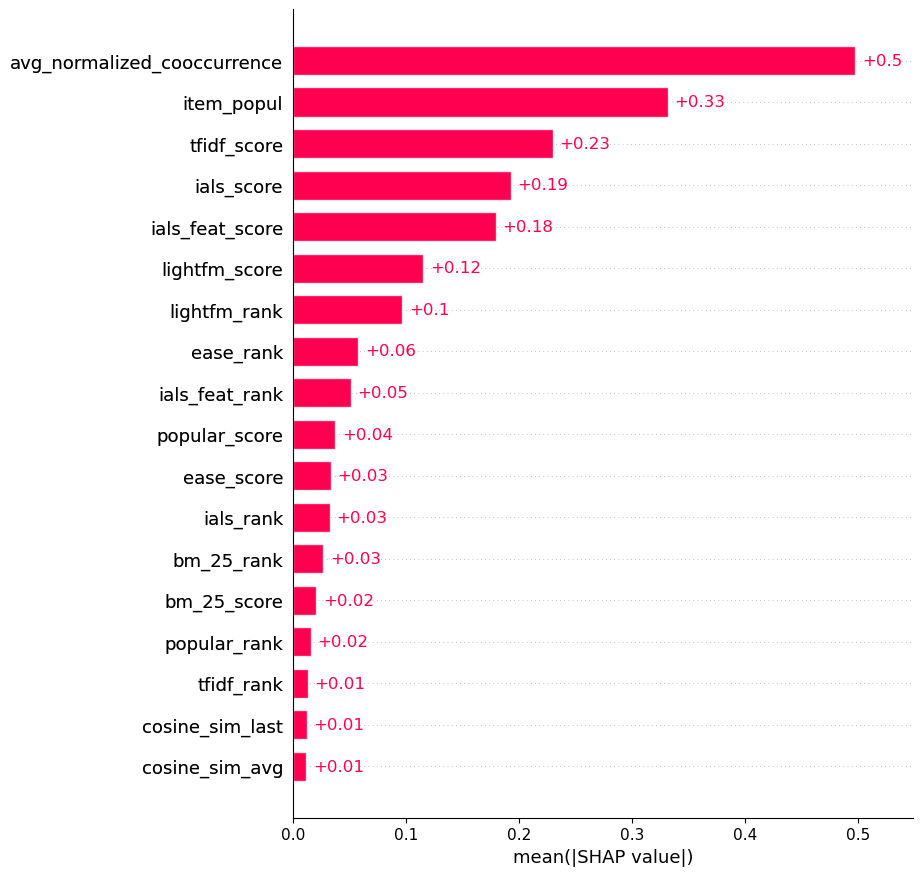

In [ ]:
import shap
explainer = shap.Explainer(listwise_model)
shap_values = explainer(test_df[cols])
shap.plots.bar(shap_values, max_display=len(cols))

In [ ]:
def get_xgboost_group(df):
    counts = df[['user_id', 'item_id']].groupby(by=['user_id']).count()['item_id'].values
    group_id = 1
    for count in counts:
        for i in range(count):
            yield group_id
        group_id += 1

In [ ]:
quids = list(get_xgboost_group(train_df))

In [ ]:
xgb_cols = cols

In [ ]:
import xgboost as xgb

In [ ]:
def get_xgboost_group(df, group_col='user_id'):
    return df.groupby(group_col).size().tolist()
train_group = get_xgboost_group(train_df)
val_group = get_xgboost_group(val_df)

In [ ]:
def objective(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 1e-3, 1.0, log=True),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        'max_leaves': trial.suggest_int('max_leaves', 16, 64),
        'tree_method': 'hist',
        'objective': 'rank:map',
        'eval_metric': 'map',
        'verbosity': 0,
        'random_state': 42,
        'n_jobs': -1
    }

    model = xgb.XGBRanker(**param)

    model.fit(
        train_df[xgb_cols],
        train_df['weight'],
        group=train_group,
        eval_set=[(val_df[xgb_cols], val_df['weight'])],
        eval_group=[val_group],
        verbose=False
    )

    evals_result = model.evals_result()
    map_val = evals_result['validation_0']['map'][-1]

    return map_val

In [ ]:
study = optuna.create_study(direction='maximize', study_name='xgb_ranker_map_optimization')
study.optimize(objective, n_trials=50)

In [ ]:
study.best_trial.params

{'n_estimators': 779,
 'max_depth': 10,
 'learning_rate': 0.028229752010860996,
 'subsample': 0.549626333911696,
 'colsample_bytree': 0.811893008351086,
 'min_child_weight': 4,
 'gamma': 0.011652061497653847,
 'lambda': 0.02160312791766124,
 'alpha': 0.06622670101921636,
 'max_leaves': 37}

In [ ]:
best_params = study.best_trial.params
best_params['tree_method'] = 'hist'
best_params['objective'] = 'rank:map'
best_params['eval_metric'] = 'map'
best_params['verbosity'] = 1
best_params['random_state'] = 42
best_params['n_jobs'] = -1

In [ ]:
xgb_model = xgb.XGBRanker(**best_params)
xgb_model.fit(train_df[xgb_cols], train_df['weight'], qid=quids)

XGBRanker(alpha=0.06622670101921636, base_score=None, booster=None,
          callbacks=None, colsample_bylevel=None, colsample_bynode=None,
          colsample_bytree=0.811893008351086, device=None,
          early_stopping_rounds=None, enable_categorical=False,
          eval_metric='map', feature_types=None, gamma=0.011652061497653847,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          lambda=0.02160312791766124, learning_rate=0.028229752010860996,
          max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
          max_delta_step=None, max_depth=10, max_leaves=37, min_child_weight=4,
          missing=nan, monotone_constraints=None, multi_strategy=None,
          n_estimators=779, n_jobs=-1, ...)

In [ ]:
xgb_df = test_df[["user_id", "item_id"]].copy()
xgb_df["xgb_score"] = xgb_model.predict(test_df[xgb_cols])
xgb_df = xgb_df.sort_values(["user_id", "xgb_score"], ascending=False)
xgb_df["xgb_rank"] = xgb_df.groupby("user_id").cumcount() + 1

In [ ]:
xgb_metrics = calc_metrics(
    metrics=metrics,
    reco=(
        xgb_df
        .rename(columns={'xgb_rank': Columns.Rank})
        [[Columns.User, Columns.Item, Columns.Rank]]
    ),
    interactions=(
        warm_test
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    prev_interactions=(
        first_train
        [[Columns.User, Columns.Item, Columns.Weight]]
    ),
    catalog=catalog
)

In [ ]:
xgb_metrics

{'hit_rate@10': 0.6434299814929056,
 'Recall@10': 0.379106261566934,
 'MRR@10': 0.4315229704620898,
 'MAP@10': 0.26646730535726526,
 'pop_bias@10': 1301.3973280382481,
 'serendipity@10': 0.00444981678025427}

In [ ]:
models_results_df_test["XGB"] = [xgb_metrics[metric] for metric in models_results_df_test.index]

## Важность признаков для XGB

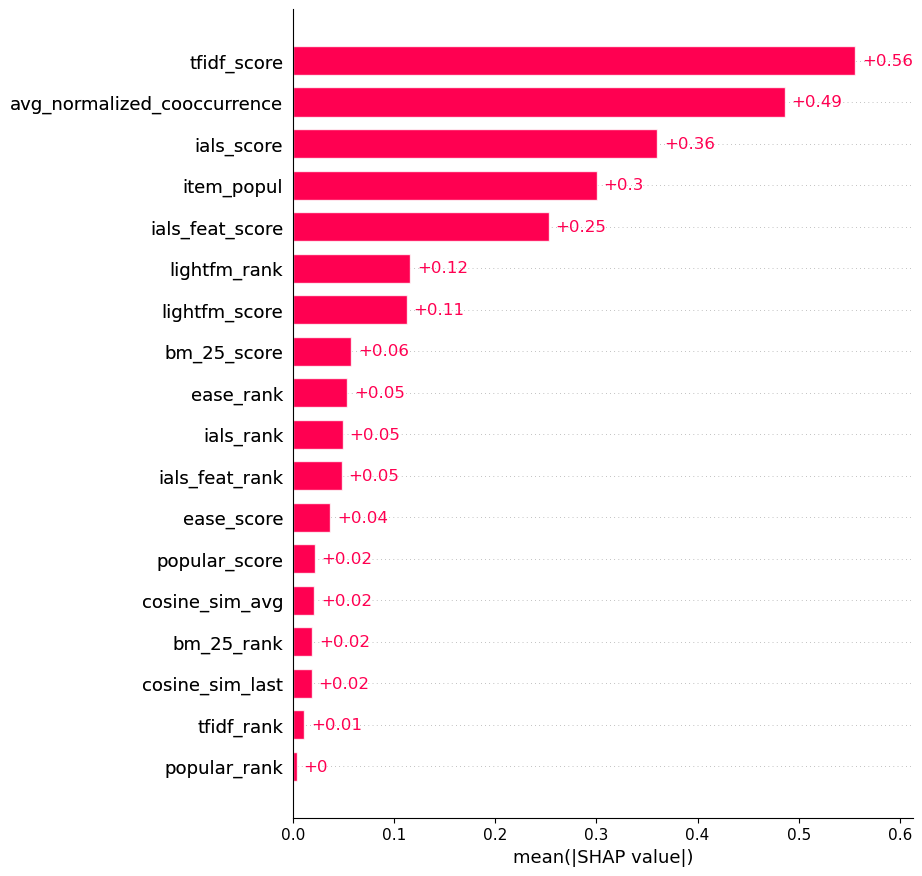

In [ ]:
explainer = shap.Explainer(xgb_model)
shap_values = explainer(test_df[xgb_cols]) #.iloc[:100_000]
shap.plots.bar(shap_values, max_display=len(cols))

## Итоговая таблица с метриками на тесте для всех моделей

In [ ]:
models_results_df_test

,Popular,LightFM,ItemKNN_BM25,ItemKNN_TF-IDF,EASE,iALS,iALS_w_f,LGBM,XGB
hit_rate@10,9.407773e-02,0.622648,0.605915,0.598627,0.435688,0.616402,0.617404,0.642312,0.643430
serendipity@10,7.830620e-07,0.004009,0.004437,0.004386,0.002359,0.004525,0.004456,0.004434,0.004450
Recall@10,3.404534e-02,0.358132,0.353177,0.349071,0.212263,0.361852,0.363202,0.378412,0.379106
MAP@10,1.223435e-02,0.242663,0.255522,0.253439,0.123670,0.254734,0.258256,0.265675,0.266467
MRR@10,3.520663e-02,0.402837,0.413104,0.410725,0.250124,0.411776,0.416565,0.430938,0.431523
pop_bias@10,4.975100e+03,1744.679908,594.380437,587.049858,1195.762781,643.808876,713.349823,1317.012365,1301.397328


# 5. Итоги

Как мы можем видеть, средняя нормализованная со-встречаемость оказалась очень важным признаком. Косинусное расстояние наоборот, видимо, по тем же причинам, что и результаты рекомендаций таким же способом, не обладает особенной важностью. 

Так как все модели первого уровня (кроме EASE) показали отличные метрики, прирост на втором уровне не такой существенный.

По итогу, вполне достаточным для хороших результатов было бы использование ItemKNN, так как это еще и самая быстрообучающаяся модель.

Признаки в силу уменьшения датасета не несут в себе большой дополнительной информации, которая могла бы сильно улучшить финальные рекомендации, а времени на обучение с ними уходит гораздо больше.

Из-за отсутствия признаков для пользователей признаки для айтемов, возможно, так же несут в себе меньше информативности, а так же без признаков для холодных пользователей невозможно делать рекомендации кроме как рекомендовать популярное.

In [ ]:
cold_test = pd.read_parquet('cold_test_2.parquet')

In [ ]:
cold_test['weight'] = 1
cold_test = cold_test.rename(
    columns={
        'dt': Columns.Datetime,
        'nm_id': 'item_id',
        'wbuser_id': 'user_id',
    }
)

In [ ]:
first_train_df = Dataset.construct(first_train)

In [ ]:
popmpd = PopularModel()
popmpd.fit(first_train_df)
popular_reco_df = popmpd.recommend(
    users=cold_test[Columns.User].unique(),
    dataset=first_train_df,
    k=10,
    filter_viewed=False,
)

In [ ]:
popmpd_metrics = calc_metrics(
    metrics=metrics,
    reco=popular_reco_df,
    interactions=cold_test,
    prev_interactions=first_train,
    catalog=catalog
)

In [ ]:
popmpd_metrics

{'hit_rate@10': 0.1707147814018043,
 'Recall@10': 0.04031198322420023,
 'MRR@10': 0.06684497648238107,
 'MAP@10': 0.015215841525624475,
 'pop_bias@10': 4975.099999999999,
 'serendipity@10': 1.3571743504998098e-06}